In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional

@dataclass
class ExperimentConfig:
    name: str
    classification_run: str
    seq2seq_run: str
    n_steps: int = 500
    chart_title: Optional[str] = None
    chart_titles: Optional[List[str]] = None

class ExperimentRunner:
    def __init__(self, api: wandb.Api):
        self.processor = DataProcessor(api)
        self.plotter = Plotter()
    
    def run_experiment(self, config: ExperimentConfig) -> None:
        """Run complete experiment workflow."""
        # Fetch data
        classification_df = self.processor.get_run_data(config.classification_run)
        seq2seq_df = self.processor.get_run_data(config.seq2seq_run)
        
        # Apply EMA smoothing
        classification_df_smooth = self.processor.apply_ema(classification_df)
        seq2seq_df_smooth = self.processor.apply_ema(seq2seq_df)
        
        # Create and display plot
        self.plotter.create_side_by_side_plots(
            classification_df_smooth[:config.n_steps],
            seq2seq_df_smooth[:config.n_steps],
            chart_titles=config.chart_titles
        )
        plt.show()

class DataProcessor:
    def __init__(self, api: wandb.Api):
        self.api = api
        self.keys = [
            "validation_in_domain/accuracy", 
            "validation_in_domain/loss",
            "validation_in_domain/sequence_accuracy",
            "training/accuracy", 
            "training/loss"
        ]
    
    def get_run_data(self, run_path: str) -> pd.DataFrame:
        """Fetch and process run data from W&B with robust column handling."""
        run = self.api.run(run_path)
        
        # Get all available history columns first
        history = list(run.scan_history())
        if not history:
            raise ValueError(f"No data found for run: {run_path}")
            
        # Get available columns from first step
        available_columns = set(history[0].keys())
        
        # Create steps DataFrame with only available columns
        requested_cols = ['Optimization Steps'] + self.keys
        cols_to_fetch = [col for col in requested_cols if col in available_columns]
        
        if not cols_to_fetch:
            raise ValueError(f"None of the required columns found in run: {run_path}")
            
        steps = pd.DataFrame([
            {k: step.get(k) for k in cols_to_fetch}
            for step in run.scan_history(cols_to_fetch)
        ])
        
        # Verify required columns exist
        required_cols = ['Optimization Steps', 'training/accuracy', 'validation_in_domain/accuracy']
        missing_cols = [col for col in required_cols if col not in steps.columns]
        
        if missing_cols:
            raise ValueError(f"Missing required columns in run {run_path}: {missing_cols}")
            
        # Create base DataFrame
        df = pd.DataFrame({
            'training/accuracy': steps['training/accuracy'].values,
            'validation_in_domain/accuracy': steps['validation_in_domain/accuracy'].values,
        }, index=steps['Optimization Steps'])
        
        # Add sequence accuracy if available
        if 'validation_in_domain/sequence_accuracy' in steps.columns:
            df['validation_in_domain/sequence_accuracy'] = steps['validation_in_domain/sequence_accuracy'].values
            
        return df
    
    @staticmethod
    def apply_ema(df: pd.DataFrame, alpha: float = 0.5) -> pd.DataFrame:
        """Apply Exponential Moving Average smoothing."""
        smoothed = df.copy()
        for col in df.columns:
            if col != 'Optimization Steps':
                smoothed[col] = df[col].ewm(alpha=alpha, adjust=False).mean()
        return smoothed

class Plotter:
    @staticmethod
    def plot_seq2seq_curves(ax: plt.Axes, df: pd.DataFrame, colors: dict, prefix: str = '') -> None:
        """Helper method to plot Seq2Seq curves consistently."""
        label_prefix = 'Seq2Seq - ' if prefix else ''
        
        # Plot training and validation accuracy
        ax.plot(df.index, df['training/accuracy'],
                color=colors['training'], linewidth=3, 
                label=f'{label_prefix}Training')
        ax.plot(df.index, df['validation_in_domain/accuracy'],
                color=colors['validation'], linewidth=3, 
                label=f'{label_prefix}Validation')
        
        # Plot sequence accuracy if available
        if 'validation_in_domain/sequence_accuracy' in df.columns:
            ax.plot(df.index, df['validation_in_domain/sequence_accuracy'],
                    color='#bc8bfc', linewidth=3,
                    label=f'{label_prefix}Validation - Entire Sequence')
    
    @staticmethod
    def create_side_by_side_plots(classification_df: pd.DataFrame, seq2seq_df: pd.DataFrame, 
                                 chart_titles: Optional[List[str]] = None) -> Tuple[plt.Figure, List[plt.Axes]]:
        plt.style.use('default')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
        
        # Default titles if none provided
        if chart_titles is None:
            chart_titles = ['Classification Task', 'Seq2Seq Task']
        elif len(chart_titles) != 2:
            raise ValueError("chart_titles must be a list of exactly 2 strings")
        
        # Classification plot
        ax1.plot(classification_df.index, classification_df['training/accuracy'],
                color='#b00000', linewidth=3, label='Training')
        ax1.plot(classification_df.index, classification_df['validation_in_domain/accuracy'],
                color='#fc0303', linewidth=3, label='Validation')
        if 'validation_in_domain/sequence_accuracy' in classification_df.columns:
            ax1.plot(classification_df.index, classification_df['validation_in_domain/sequence_accuracy'],
                    color='#bc8bfc', linewidth=3,
                    label=f'Validation - Entire Sequence')
        ax1.set_title(chart_titles[0], fontsize=16, fontweight='bold', pad=20)
        
        # Seq2Seq plot
        Plotter.plot_seq2seq_curves(ax2, seq2seq_df, 
                                  colors={'training': '#013491', 
                                         'validation': '#0259fa'})
        ax2.set_title(chart_titles[1], fontsize=16, fontweight='bold', pad=20)
        
        # Style both plots
        for ax in [ax1, ax2]:
            ax.set_facecolor('#f8f9fa')
            ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
            ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
            ax.set_xlabel('Optimization Steps', fontsize=16, fontweight='bold')
            ax.set_ylabel('Accuracy', fontsize=16, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            ax.set_ylim(-0.05, 1.05)
            ax.legend(loc='lower right', frameon=True, fancybox=True, 
                    shadow=True, fontsize=16)
        
        fig.patch.set_facecolor('#ffffff')
        plt.tight_layout()
        return fig, [ax1, ax2]
    
    @staticmethod
    def create_plot(classification_df: pd.DataFrame, seq2seq_df: pd.DataFrame, 
                    chart_title: Optional[str] = None) -> Tuple[plt.Figure, plt.Axes]:
        plt.style.use('default')
        fig, ax = plt.subplots(figsize=(12, 7), dpi=150)
        
        # Plot classification data
        ax.plot(classification_df.index, classification_df['training/accuracy'],
                color='#b00000', linewidth=3, label='Classification - Training')
        ax.plot(classification_df.index, classification_df['validation_in_domain/accuracy'],
                color='#fc0303', linewidth=3, label='Classification - Validation')
        
        # Plot Seq2Seq data with prefix for legend
        Plotter.plot_seq2seq_curves(ax, seq2seq_df, 
                                  colors={'training': '#013491', 
                                         'validation': '#0259fa'},
                                  prefix='Seq2Seq')
        
        # Style plot
        ax.set_facecolor('#f8f9fa')
        fig.patch.set_facecolor('#ffffff')
        ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
        
        # Labels and title
        ax.set_xlabel('Optimization Steps', fontsize=16, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=16, fontweight='bold')
        
        # Set custom title or default
        if chart_title is None:
            chart_title = 'Training and Validation Accuracy Comparison\nClassification vs Seq2Seq Models'
        ax.set_title(chart_title, fontsize=16, fontweight='bold', pad=20)
        
        # Legend and formatting
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
                 borderaxespad=0, frameon=True, fancybox=True,
                 shadow=True, fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        ax.set_ylim(-0.05, 1.05)
        
        plt.tight_layout()
        return fig, ax

In [2]:
api = wandb.Api()



Running experiment: Modular Divison (training on 40% of data)


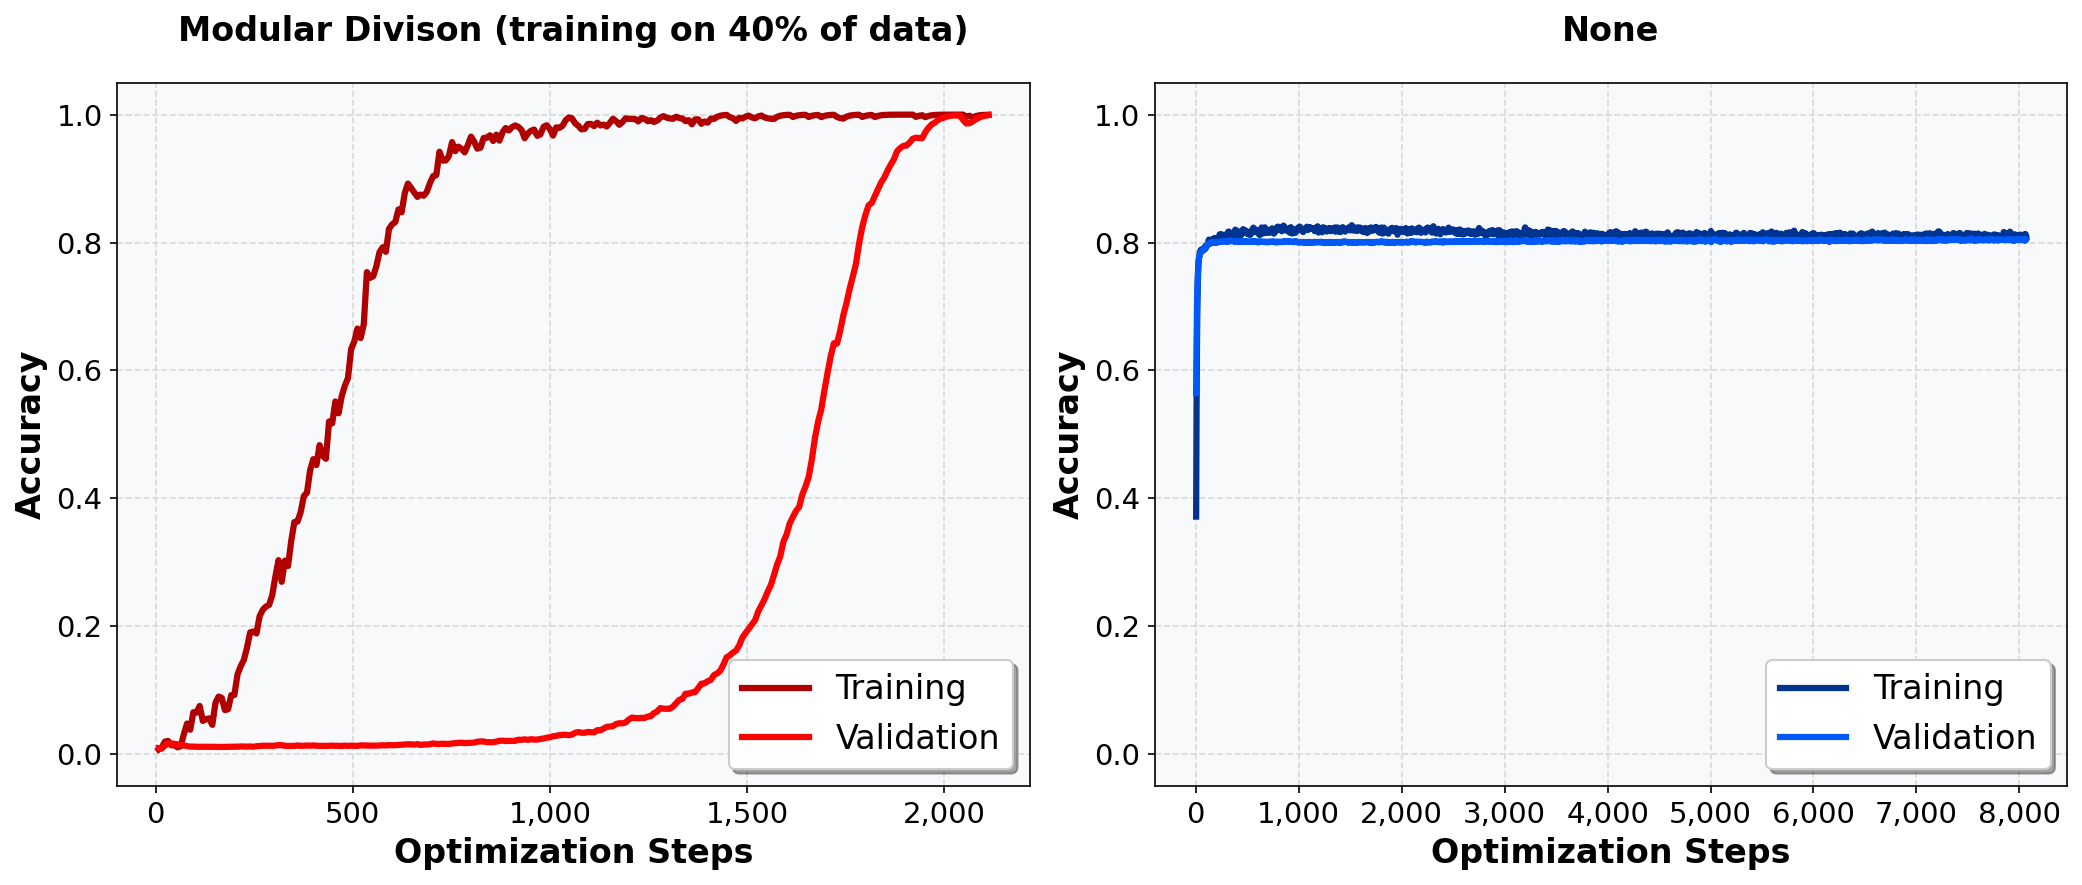

In [3]:
# Introduction Chart

experiments = [
    ExperimentConfig(
        name="Modular Divison (training on 40% of data)",
        classification_run="philliplakaschus/grokking/p0yvoa1l",
        seq2seq_run="philliplakaschus/grokking/d6p4imdm",
        n_steps=4000,
        chart_titles=["Modular Divison (training on 40% of data)", "None"]
    )
]

# Run experiments
runner = ExperimentRunner(api)
for experiment in experiments:
    print(f"\nRunning experiment: {experiment.name}")
    runner.run_experiment(experiment)

# Multitask Results

In [ ]:
classification_urls = {"run1": "https://wandb.ai/philliplakaschus/grokking/runs/63iq5tir", "run2": ""}
seq2seq_urls = {"run1": "", "run2": ""}